In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import pandas as pd
from omegaconf import OmegaConf
from pathlib import Path
from pprint import pprint
from torch import nn
from torchinfo import summary
import torchvision
# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
# mycode
from repo import REPO
from ml_utilities.output_loader.job_output import SweepResult, JobResult
from ml_utilities.output_loader import create_job_output_loader
from ml_utilities.output_loader.plot import plot_sweep_summary, plot_data_log_values
from ml_utilities.torch_models import get_model_config
from ml_utilities.data_utils import show_images
from ml_utilities.torch_models.resnet import Resnet

# 13.0.0 CIFAR10 Dataset & Model setup

This notebook is a debug notebook to create the config for CIFAR10 experiments and to do an initial hyperparameter tuning.


## 0. Load CIFAR10 dataset

In [2]:
data_dir = '/system/user/beck/pwbeck/data'

In [3]:
data_cfg = """
data:
  dataset: cifar10
  dataset_kwargs:
    data_root_path: /system/user/beck/pwbeck/data
  dataset_split:
    train_val_split: 0.9
  dataset_transforms:
    image_transforms:
    - RandomHorizontalFlip
    - RandomCrop:
        size: 32
        padding: 4
    tensor_transforms: 
    joint_tensor_transforms: 
    enable_transforms: True
"""
data_cfg = OmegaConf.create(data_cfg)

In [4]:
from erank.data.datasetgenerator import DatasetGenerator
ds_generator = DatasetGenerator(**data_cfg.data)
ds_generator.generate_dataset()

Files already downloaded and verified


In [5]:
ds_generator.train_split.dataset

In [6]:
len(ds_generator.train_split), len(ds_generator.val_split)

(45000, 5000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


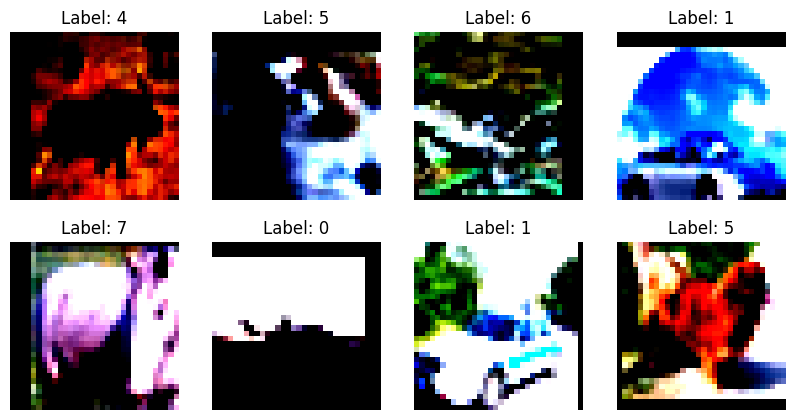

In [7]:
show_images(ds_generator.train_split, 10)

## 1. Load ResNet model, Compare Residual option A and B

In [9]:
# Option A: #params = 269,722
model_cfg = get_model_config('resnet20-cifar10-A')
print(OmegaConf.to_yaml(model_cfg))

name: resnet
model_kwargs:
  in_channels: 3
  act_fn: relu
  residual_option: A
  input_layer_config:
    kernel_size: 3
    out_channels: 16
    bias: false
    batch_norm: true
    stride: 1
    padding: 1
  resnet_blocks_config:
  - out_channels: 16
    num_residual_blocks: 3
  - out_channels: 32
    num_residual_blocks: 3
  - out_channels: 64
    num_residual_blocks: 3
  linear_output_units:
  - 10
  model_initializer: kaiming_normal
  batchnorm_initializer: uniform



In [10]:
resnet_model = Resnet(**model_cfg.model_kwargs)
summary(resnet_model, input_data=torch.randn(128, 3, 32, 32), depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
Resnet                                        [128, 10]                 --
├─Sequential: 1-1                             [128, 10]                 --
│    └─Sequential: 2-1                        [128, 16, 32, 32]         --
│    │    └─Conv2d: 3-1                       [128, 16, 32, 32]         432
│    │    └─BatchNorm2d: 3-2                  [128, 16, 32, 32]         32
│    │    └─ReLU: 3-3                         [128, 16, 32, 32]         --
│    └─Sequential: 2-2                        [128, 64, 8, 8]           --
│    │    └─Sequential: 3-4                   [128, 16, 32, 32]         --
│    │    │    └─_ResidualBlock: 4-1          [128, 16, 32, 32]         4,672
│    │    │    └─_ResidualBlock: 4-2          [128, 16, 32, 32]         4,672
│    │    │    └─_ResidualBlock: 4-3          [128, 16, 32, 32]         4,672
│    │    └─Sequential: 3-5                   [128, 32, 16, 16]         --
│    │    

In [11]:
# Option B: #params = 272,474
model_cfg = """
# model_cfg: resnet20-cifar10
name: resnet
model_kwargs:
  in_channels: 3
  act_fn: relu
  residual_option: B
  input_layer_config:
    kernel_size: 3
    out_channels: 16
    bias: false
    batch_norm: true
    stride: 1
    padding: 1
  resnet_blocks_config:
    - out_channels: 16
      num_residual_blocks: 3
    - out_channels: 32
      num_residual_blocks: 3
    - out_channels: 64
      num_residual_blocks: 3
  linear_output_units:
    - 10
"""
model_cfg = OmegaConf.create(model_cfg)
resnet_model = Resnet(**model_cfg.model_kwargs)
summary(resnet_model, input_data=torch.randn(128, 3, 32, 32), depth=4)

Layer (type:depth-idx)                             Output Shape              Param #
Resnet                                             [128, 10]                 --
├─Sequential: 1-1                                  [128, 10]                 --
│    └─Sequential: 2-1                             [128, 16, 32, 32]         --
│    │    └─Conv2d: 3-1                            [128, 16, 32, 32]         432
│    │    └─BatchNorm2d: 3-2                       [128, 16, 32, 32]         32
│    │    └─ReLU: 3-3                              [128, 16, 32, 32]         --
│    └─Sequential: 2-2                             [128, 64, 8, 8]           --
│    │    └─Sequential: 3-4                        [128, 16, 32, 32]         --
│    │    │    └─_ResidualBlock: 4-1               [128, 16, 32, 32]         4,672
│    │    │    └─_ResidualBlock: 4-2               [128, 16, 32, 32]         4,672
│    │    │    └─_ResidualBlock: 4-3               [128, 16, 32, 32]         4,672
│    │    └─Sequential: 3

# 13.0 CIFAR10 Standard Training influence Augmentation

## A. Experiment config

In [11]:
config_yaml = """
run_config:
  exec_type: parallel
  hostname: dragonfly
  gpu_ids: [0,1]
  runs_per_gpu: 2
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      - run_handler
      notes: null
      group: ${config.experiment_data.experiment_tag}
      job_type: run_handler

seeds: [42]

sweep:
  type: grid
  axes: 
  - parameter: data.dataset_transforms.enable_transforms
    vals: [True] #[True, False]
  - parameter: trainer.optimizer_scheduler.optimizer_kwargs.lr
    vals: [0.1, 0.075, 0.05, 0.025]
  # - parameter: trainer.optimizer_scheduler.optimizer_kwargs.weight_decay
  #   vals: [0.0, 0.001, 0.005]
  # - parameter: trainer.batch_size
  #   vals: [64, 256, 512]
    
start_num: 3

config:
  experiment_data:
    entity: jkuiml-fsl
    project_name: tflearning
    experiment_tag: '13.0'
    experiment_type: startnum_${start_num}
    experiment_name: cifar10-${config.experiment_data.experiment_tag}.${start_num}-resnet-B
    experiment_dir: null
    experiment_notes: 
    job_name: null
    seed: 0
    hostname: null
    gpu_id: 0
  wandb:
    init:
      tags:
      - ${config.experiment_data.experiment_tag}_exps
      notes: ${config.experiment_data.experiment_notes}
      group: ${config.experiment_data.experiment_tag}
      job_type: ${config.experiment_data.experiment_type}
    watch:
      log: null
      log_freq:

  model:
    model_cfg: resnet20-cifar10-B
    # name: resnet
    # model_kwargs:
    #   in_channels: 3
    #   act_fn: relu
    #   residual_option: B
    #   input_layer_config:
    #     kernel_size: 3
    #     out_channels: 16
    #     bias: false
    #     batch_norm: true
    #     stride: 1
    #     padding: 1
    #   resnet_blocks_config:
    #     - out_channels: 16
    #       num_residual_blocks: 3
    #     - out_channels: 32
    #       num_residual_blocks: 3
    #     - out_channels: 64
    #       num_residual_blocks: 3
    #   linear_output_units:
    #     - 10
    init_model: null

  trainer:
    training_setup: supervised
    n_steps: 64e3
    log_train_step_every: 1
    log_additional_train_step_every_multiplier: 1
    log_additional_logs: true
    val_every: 500
    save_every: 10000
    early_stopping_patience: 64e3
    batch_size: 128
    optimizer_scheduler:
      optimizer_name: SGD
      optimizer_kwargs:
        lr: 0.01 #0.1
        momentum: 0.9
        weight_decay: 0.0001
      lr_scheduler_name: MultiStepLR
      lr_scheduler_kwargs:
        milestones: [32e3, 48e3]
        gamma: 0.1

    loss: crossentropy
    metrics:
    - Accuracy
    num_workers: 4
    verbose: false
  data:
    dataset: cifar10
    dataset_kwargs:
      data_root_path: /system/user/beck/pwbeck/data
    dataset_split:
      train_val_split: 0.9
      # restrict_n_samples_train_task: 100
    dataset_transforms:
      image_transforms:
      - RandomHorizontalFlip
      - RandomCrop:
          size: 32
          padding: 4
      tensor_transforms: 
      joint_tensor_transforms: 
      enable_transforms: True
"""
cfg = OmegaConf.create(config_yaml)

In [12]:
run_command = REPO.create_experiment(cfg, override=True)
print(run_command)

python run_sweep.py --config-name cifar10-13.0.3-resnet-B.yaml


### Sweep result

In [ ]:
sweepr = REPO.get_output_loader(cfg)
print(sweepr)

In [ ]:
# failed_jobs = sweepr.get_failed_jobs()
# failed_jobs # No failed jobs

## B. Analysis 1

In [ ]:
pprint(sweepr.available_log_columns)

In [ ]:
sw_summary = sweepr.get_summary()

In [ ]:
sw_summary